#### Chapter 18
### Analyzing Neural Time Series Data
Python code for Chapter 18 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fftpack import fft, ifft
from scipy.stats import zscore

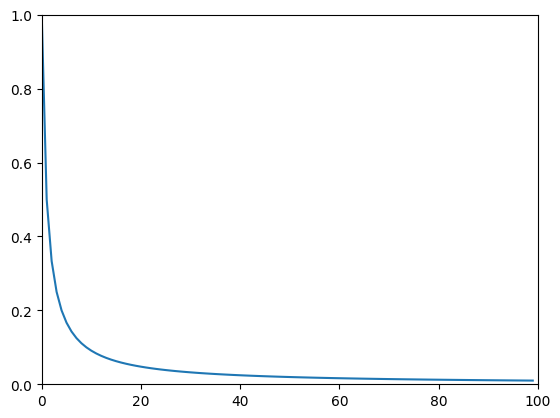

In [2]:
## Figure 18.1

# 1/f function
c = 1
x = 1
plt.plot(c / np.arange(1, 101)**x)
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.show()

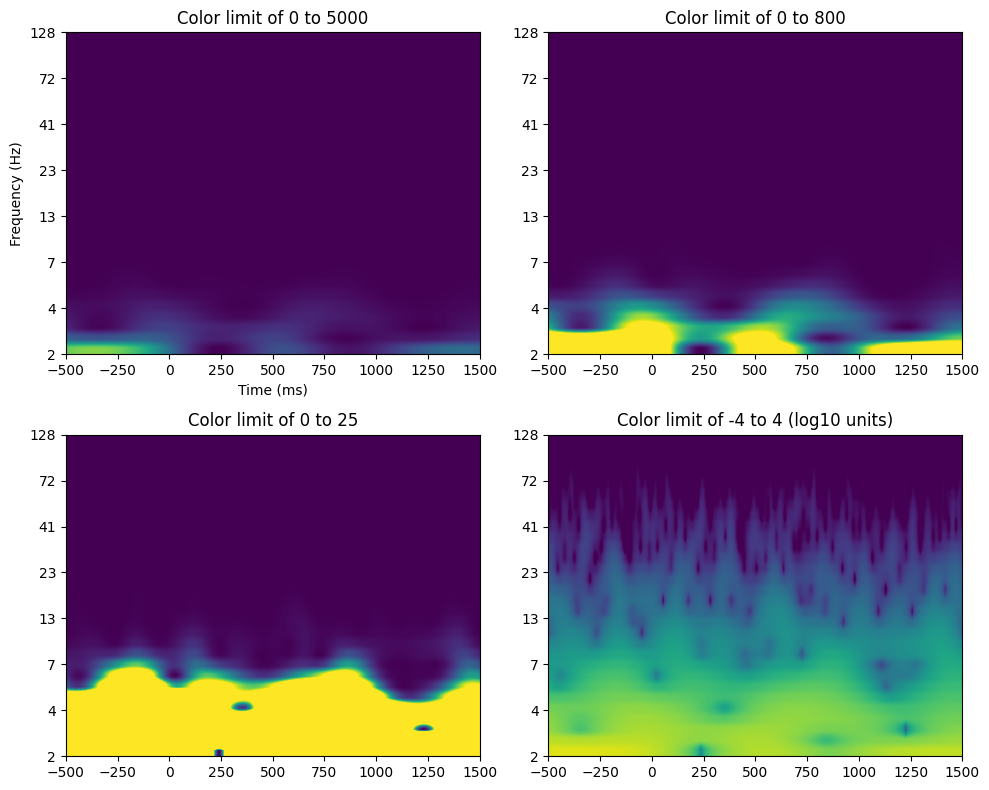

In [3]:
## Figure 18.2

# Load sample EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Wavelet parameters
min_freq = 2
max_freq = 128
num_frex = 30

# Other wavelet parameters
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
time = np.arange(-1, 1 + 1/EEG['srate'], 1/EEG['srate'])
half_of_wavelet_size = (len(time) - 1) // 2

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = int(2**np.ceil(np.log2(n_convolution)))
wavelet_cycles = 4

# FFT of data (note: this doesn't change on frequency iteration)
fft_data = fft(EEG['data'][22, :, 0], n_conv_pow2)

# Initialize output time-frequency data
tf_data = np.zeros((len(frequencies), EEG['pnts'][0][0]))

for fi in range(len(frequencies)):
    # Create wavelet and get its FFT
    wavelet = (np.pi * frequencies[fi] * np.sqrt(np.pi))**-0.5 * np.exp(2 * 1j * np.pi * frequencies[fi] * time) * np.exp(-time**2 / (2 * (wavelet_cycles / (2 * np.pi * frequencies[fi]))**2)) / frequencies[fi]
    fft_wavelet = fft(wavelet, n_conv_pow2)
    
    # Run convolution
    convolution_result_fft = ifft(fft_wavelet * fft_data, n_conv_pow2)
    convolution_result_fft = convolution_result_fft[:n_convolution]
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size: -half_of_wavelet_size]
    
    # Put power data into time-frequency matrix
    tf_data[fi, :] = np.abs(convolution_result_fft)**2

# Plot results
plt.figure(figsize=(10, 8))
ytickskip = np.arange(2, num_frex+4, 4)

# Subplot 1
plt.subplot(221)
plt.imshow(tf_data, aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(0, 5000)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.gca().invert_yaxis()
plt.title('Color limit of 0 to 5000')

# Subplot 2
plt.subplot(222)
plt.imshow(tf_data, aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(0, 800)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.gca().invert_yaxis()
plt.title('Color limit of 0 to 800')

# Subplot 3
plt.subplot(223)
plt.imshow(tf_data, aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(0, 25)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.gca().invert_yaxis()
plt.title('Color limit of 0 to 25')

# Subplot 4
plt.subplot(224)
plt.imshow(np.log10(tf_data), aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(-4, 4)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.gca().invert_yaxis()
plt.title('Color limit of -4 to 4 (log10 units)')

plt.tight_layout()
plt.show()

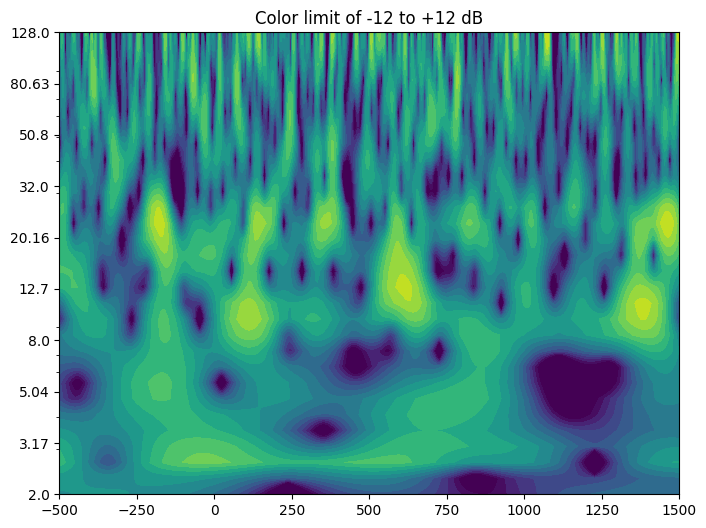

In [4]:
## Figure 18.3

# Define baseline period
baselinetime = [-500, -200]  # in ms

# Convert baseline window time to indices
baselineidx = [np.argmin(np.abs(EEG['times'][0] - bt)) for bt in baselinetime]

# dB-correct
baseline_power = np.mean(tf_data[:, baselineidx[0]:baselineidx[1]], axis=1)
dbconverted = 10 * np.log10(tf_data / baseline_power[:, np.newaxis])

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(EEG['times'][0], frequencies, dbconverted, 40, cmap='viridis')
plt.clim(-12, 12)
plt.xlim([-500, 1500])
plt.title('Color limit of -12 to +12 dB')
plt.yscale('log')
ylabels = np.round(np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1]),10)*100)/100
plt.yticks(ylabels, ylabels)
plt.show()

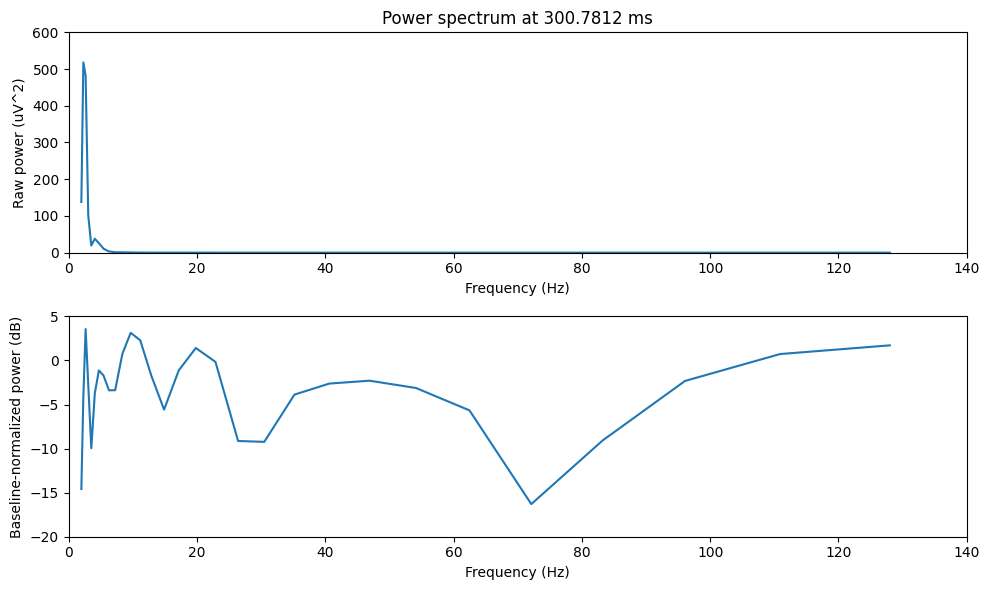

In [5]:
## Figure 18.4

# Time to plot
time2plot = 300  # in ms

# Find the index of the time to plot
timeidx = np.argmin(np.abs(EEG['times'][0] - time2plot))

# Plot frequencies
plt.figure(figsize=(10, 6))

# Subplot 1: Raw power
plt.subplot(211)
plt.plot(frequencies, tf_data[:, timeidx])
plt.title(f'Power spectrum at {EEG["times"][0][timeidx]:.4f} ms')
plt.xlim([0, 140])
plt.ylim([0, 600])
plt.ylabel('Raw power (uV^2)')
plt.xlabel('Frequency (Hz)')

# Subplot 2: Baseline-normalized power
plt.subplot(212)
plt.plot(frequencies, dbconverted[:, timeidx])
plt.xlim([0, 140])
plt.ylim([-20, 5])
plt.ylabel('Baseline-normalized power (dB)')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

In [6]:
## Figure 18.5

# This figure was created by changing the color limits of figure 18.3

dB of -2 corresponds to -36.9% change.
dB of +2 corresponds to +58.5% change.


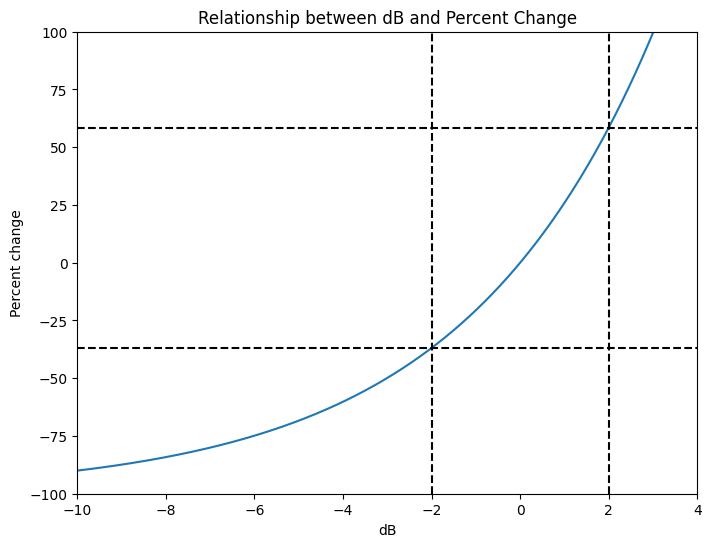

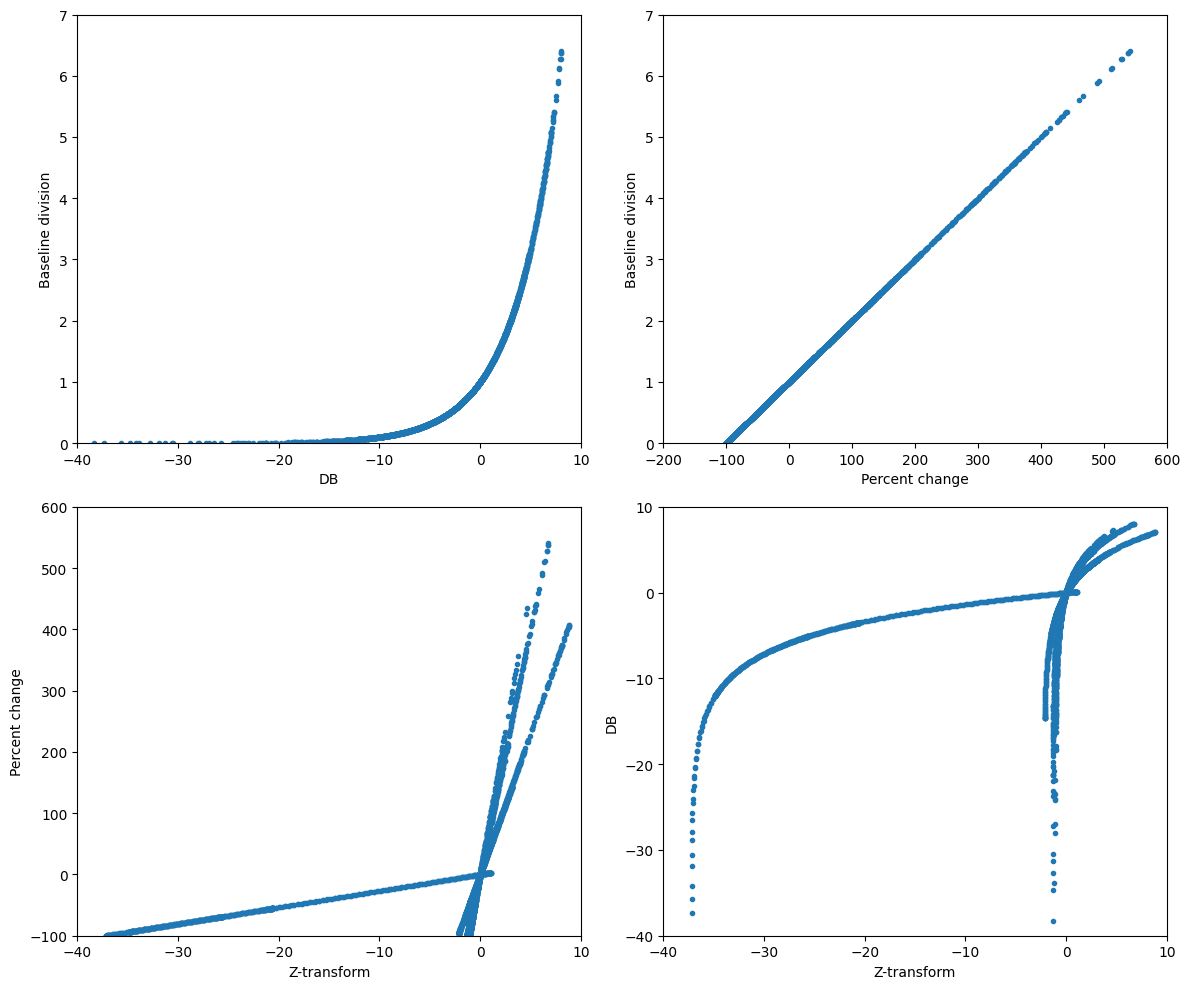

In [7]:
## Figure 18.6

# Activity and baseline
activity = np.arange(1, 20.001, 0.01)
baseline = 10

# Compute dB and percent change
db = 10 * np.log10(activity / baseline)
pc = 100 * (activity - baseline) / baseline

# Plot
plt.figure(figsize=(8, 6))
plt.plot(db, pc)
plt.xlim([-10, 4])
plt.ylim([-100, 100])
plt.xlabel('dB')
plt.ylabel('Percent change')

# Find indices where db is closest to -/+2
dbOf2 = np.argmin(np.abs(db - 2))
dbOfminus2 = np.argmin(np.abs(db - (-2)))

print(f'dB of -2 corresponds to {pc[dbOfminus2]:.1f}% change.')
print(f'dB of +2 corresponds to +{pc[dbOf2]:.1f}% change.')

plt.axvline(x=db[dbOf2], color='k', linestyle='--')
plt.axhline(y=pc[dbOf2], color='k', linestyle='--')
plt.axvline(x=db[dbOfminus2], color='k', linestyle='--')
plt.axhline(y=pc[dbOfminus2], color='k', linestyle='--')

plt.title('Relationship between dB and Percent Change')
plt.show()

# Real data: percent change vs. baseline division
plt.figure(figsize=(12, 10))

# Baseline power and percent change
baseline_power = np.mean(tf_data[:, baselineidx[0]:baselineidx[1]], axis=1)
pctchange = 100 * (tf_data - baseline_power[:, np.newaxis]) / baseline_power[:, np.newaxis]

# Subplot 1: Baseline division
plt.subplot(221)
baselinediv = tf_data / baseline_power[:, np.newaxis]
plt.plot(dbconverted.flatten('F')[::5], baselinediv.flatten('F')[::5], '.')
plt.xlim([-40, 10])
plt.ylim([0, 7])
plt.xlabel('DB')
plt.ylabel('Baseline division')

# Subplot 2: dB vs. baseline division
plt.subplot(222)
plt.plot(pctchange.flatten('F')[::5], baselinediv.flatten('F')[::5], '.')
plt.xlim([-200, 600])
plt.ylim([0, 7])
plt.xlabel('Percent change')
plt.ylabel('Baseline division')

# Subplot 3: Z-transform vs. percent change
plt.subplot(223)
baselineZ = (tf_data - baseline_power[:, np.newaxis]) / np.std(tf_data[:, baselineidx[0]:baselineidx[1]], axis=1, ddof=1)[:, np.newaxis]
plt.plot(baselineZ.flatten('F')[::5], pctchange.flatten('F')[::5], '.')
plt.xlim([-40, 10])
plt.ylim([-100, 600])
plt.xlabel('Z-transform')
plt.ylabel('Percent change')

# Subplot 4: Z-transform vs. dB
plt.subplot(224)
plt.plot(baselineZ.flatten('F')[::5], dbconverted.flatten('F')[::5], '.')
plt.xlim([-40, 10])
plt.ylim([-40, 10])
plt.xlabel('Z-transform')
plt.ylabel('DB')

plt.tight_layout()
plt.show()

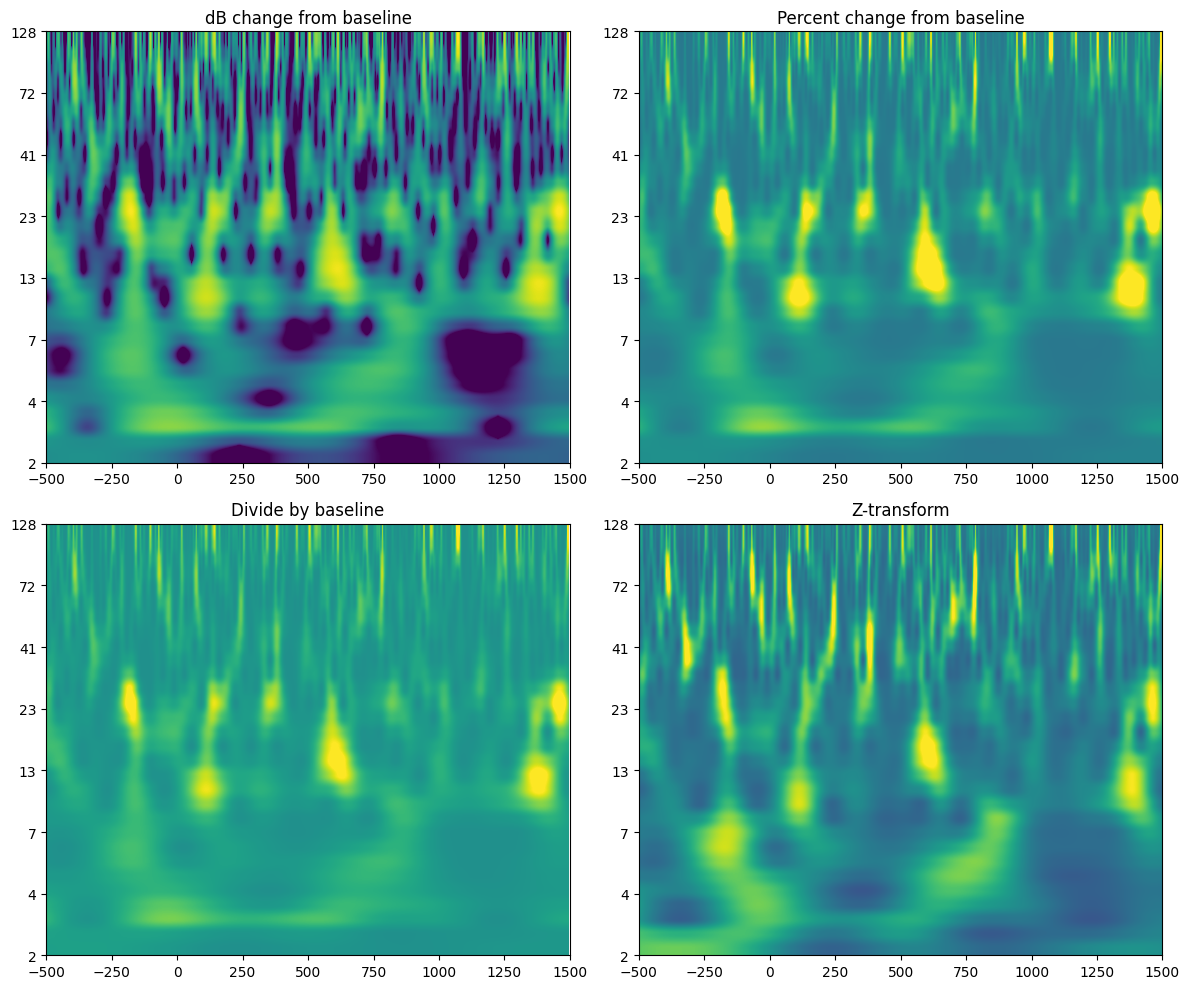

In [8]:
## Figure 18.7

# Plot dB-converted power, percent-change, divide by baseline, and z-transform
plt.figure(figsize=(12, 10))

# Subplot 1: dB change from baseline
plt.subplot(221)
plt.imshow(dbconverted, aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(-10, 10)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.gca().invert_yaxis()
plt.title('dB change from baseline')

# Subplot 2: Percent change from baseline
plt.subplot(222)
pctchange = 100 * (tf_data - baseline_power[:, np.newaxis]) / baseline_power[:, np.newaxis]
plt.imshow(pctchange, aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(-500, 500)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.gca().invert_yaxis()
plt.title('Percent change from baseline')

# Subplot 3: Divide by baseline
plt.subplot(223)
baselinediv = tf_data / baseline_power[:, np.newaxis]
plt.imshow(baselinediv, aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(-7.5, 7.5)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.gca().invert_yaxis()
plt.title('Divide by baseline')

# Subplot 4: Z-transform
plt.subplot(224)
baselineZ = zscore(tf_data, axis=1, ddof=1)
plt.imshow(baselineZ, aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], ytickskip[-1], ytickskip[0]])
plt.clim(-3.5, 3.5)
plt.xlim([-500, 1500])
plt.yticks(ytickskip, np.round(frequencies[ytickskip-1]).astype(int))
plt.gca().invert_yaxis()
plt.title('Z-transform')

plt.tight_layout()
plt.show()

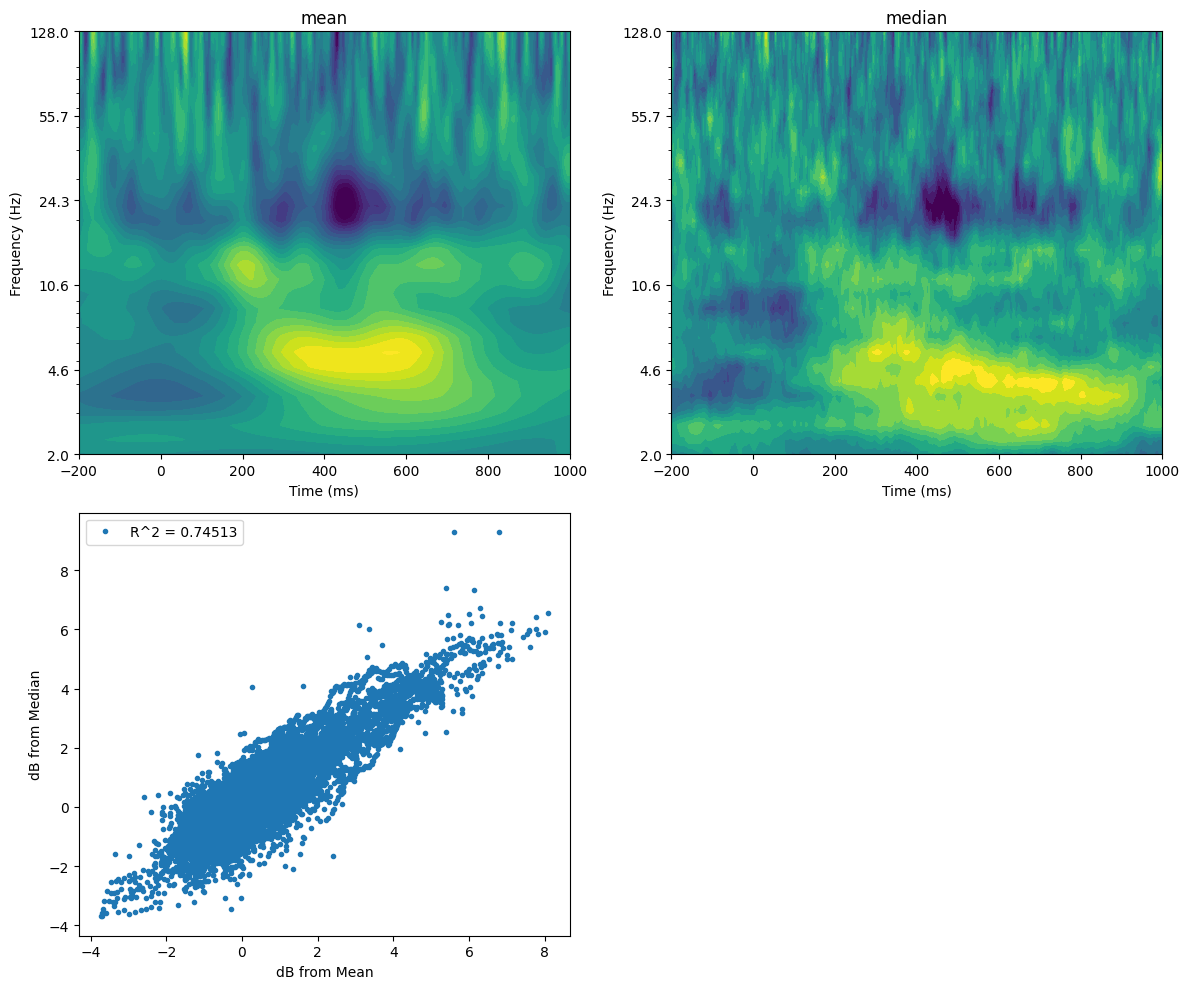

In [9]:
## Figure 18.8

# Define baseline period and channel to plot
chan2plot = 'FCz'  # p1 for figure 18.11
baselinetime = [-500, -200]  # in ms

# Convert baseline window time to indices
baselineidx = [np.argmin(np.abs(EEG['times'][0] - bt)) for bt in baselinetime]

# Initialize time-frequency data
tf_data = np.zeros((2, len(frequencies), EEG['pnts'][0][0]))

# Update FFT parameters for multiple trials
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = int(2**np.ceil(np.log2(n_convolution)))

# FFT of data
fft_data = fft(EEG['data'][EEG['chanlocs'][0]['labels']==chan2plot].flatten('F'), n_conv_pow2)

# Convolution for each frequency
for fi in range(len(frequencies)):
    # Create wavelet and get its FFT
    wavelet = (np.pi * frequencies[fi] * np.sqrt(np.pi))**-0.5 * np.exp(2 * 1j * np.pi * frequencies[fi] * time) * np.exp(-time**2 / (2 * (wavelet_cycles / (2 * np.pi * frequencies[fi]))**2)) / frequencies[fi]
    fft_wavelet = fft(wavelet, n_conv_pow2)
    
    # Run convolution
    convolution_result_fft = ifft(fft_wavelet * fft_data, n_conv_pow2)
    convolution_result_fft = convolution_result_fft[:n_convolution]
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size: -half_of_wavelet_size]
    convolution_result_fft = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Save single-trial data from one frequency band
    if fi == 5:
        convdat2keep = convolution_result_fft
    
    # Put power data into time-frequency matrix
    tf_data[0, fi, :] = np.mean(np.abs(convolution_result_fft)**2, axis=1)
    tf_data[1, fi, :] = np.median(np.abs(convolution_result_fft)**2, axis=1)

# dB-correct and plot
labelz = ['mean', 'median']
plt.figure(figsize=(12, 10))
for i in range(2):
    baseline_power = np.mean(tf_data[i, :, baselineidx[0]:baselineidx[1]], axis=1)
    dbconverted = 10 * np.log10(tf_data[i] / baseline_power[:, np.newaxis])
    
    # Plot
    plt.subplot(2, 2, i + 1)
    plt.contourf(EEG['times'][0], frequencies, dbconverted, 40, cmap='viridis')
    plt.clim(-3, 3)
    plt.xlim([-200, 1000])
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.yscale('log')
    ylabels = np.round(np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1]),6), 1)
    plt.yticks(ylabels, ylabels)
    plt.title(labelz[i])

# Plot relationship between mean and median
plt.subplot(223)
db_mean = 10 * np.log10(tf_data[0] / np.mean(tf_data[0, :, baselineidx[0]:baselineidx[1]], axis=1)[:, np.newaxis])
db_medn = 10 * np.log10(tf_data[1] / np.mean(tf_data[1, :, baselineidx[0]:baselineidx[1]], axis=1)[:, np.newaxis])
plt.plot(db_mean.flatten('F'), db_medn.flatten('F'), '.')
r = np.corrcoef(db_mean.flatten('F'), db_medn.flatten('F'))[0, 1]
plt.legend([f'R^2 = {r**2:.5f}'])
plt.xlabel('dB from Mean')
plt.ylabel('dB from Median')

plt.tight_layout()
plt.show()

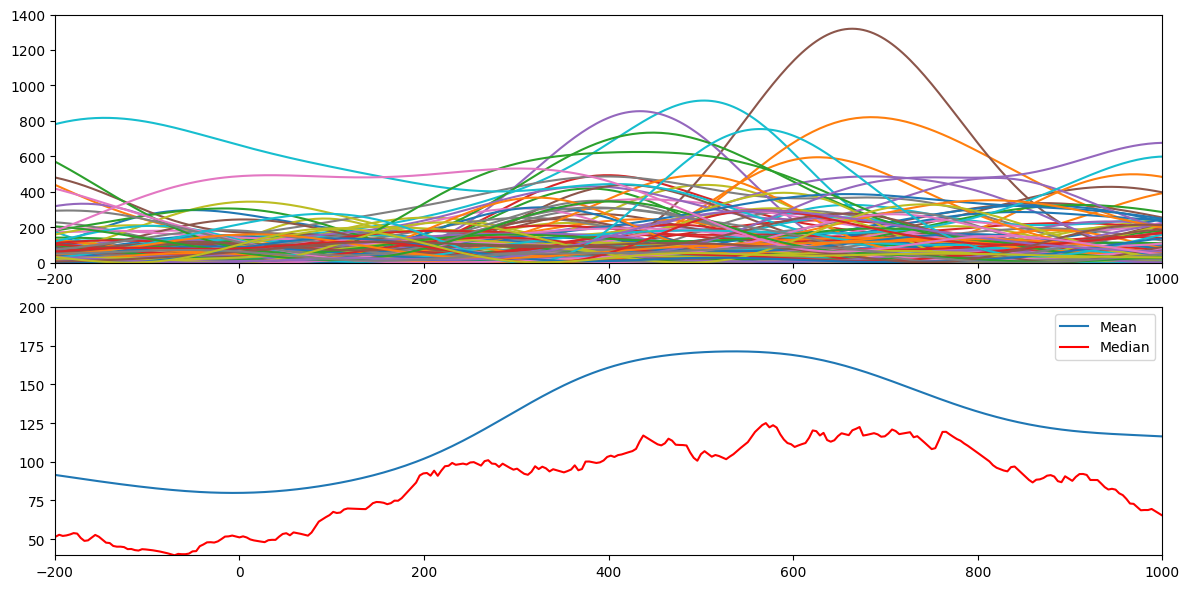

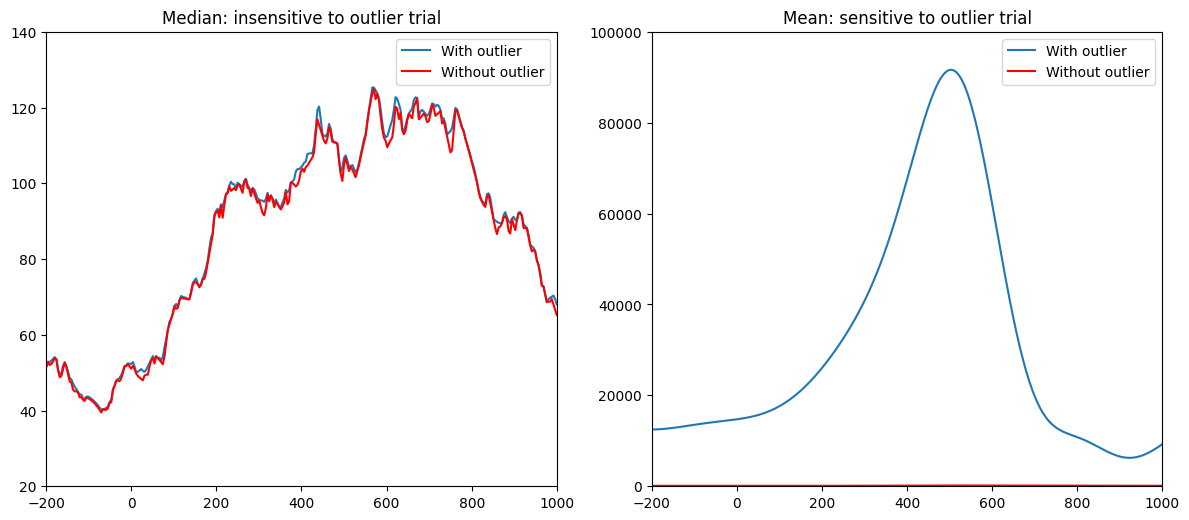

In [10]:
## Figure 18.9

# Plot all trials, mean, and median
plt.figure(figsize=(12, 6))

# Subplot 1: All trials
plt.subplot(211)
plt.plot(EEG['times'][0], np.abs(convdat2keep)**2)
plt.xlim([-200, 1000])
plt.ylim([0, 1400])

# Subplot 2: Mean and median
plt.subplot(212)
plt.plot(EEG['times'][0], np.mean(np.abs(convdat2keep)**2, axis=1), label='Mean')
plt.plot(EEG['times'][0], np.median(np.abs(convdat2keep)**2, axis=1), 'r', label='Median')
plt.xlim([-200, 1000])
plt.ylim([np.min(np.median(np.abs(convdat2keep)**2, axis=1)), 200])
plt.legend()

plt.tight_layout()
plt.show()

# Add an outlier trial
convdat2keep1 = np.column_stack((convdat2keep, convdat2keep[:, 9] * 100))
# Note we save to a new variable so the cell can be re-run without issue 
# The Matlab code does not do this and gives different plots when the single section is re-run

plt.figure(figsize=(12, 10))

# Subplot 3: Median with and without outlier
plt.subplot(223)
plt.plot(EEG['times'][0], np.median(np.abs(convdat2keep1)**2, axis=1), label='With outlier')
plt.plot(EEG['times'][0], np.median(np.abs(convdat2keep1[:, :-1])**2, axis=1), 'r', label='Without outlier')
plt.xlim([-200, 1000])
plt.ylim([20, 140])
plt.legend()
plt.title('Median: insensitive to outlier trial')

# Subplot 4: Mean with and without outlier
plt.subplot(224)
plt.plot(EEG['times'][0], np.mean(np.abs(convdat2keep1)**2, axis=1), label='With outlier')
plt.plot(EEG['times'][0], np.mean(np.abs(convdat2keep1[:, :-1])**2, axis=1), 'r', label='Without outlier')
plt.xlim([-200, 1000])
plt.ylim([0, 100000])
plt.legend()
plt.title('Mean: sensitive to outlier trial')

plt.tight_layout()
plt.show()

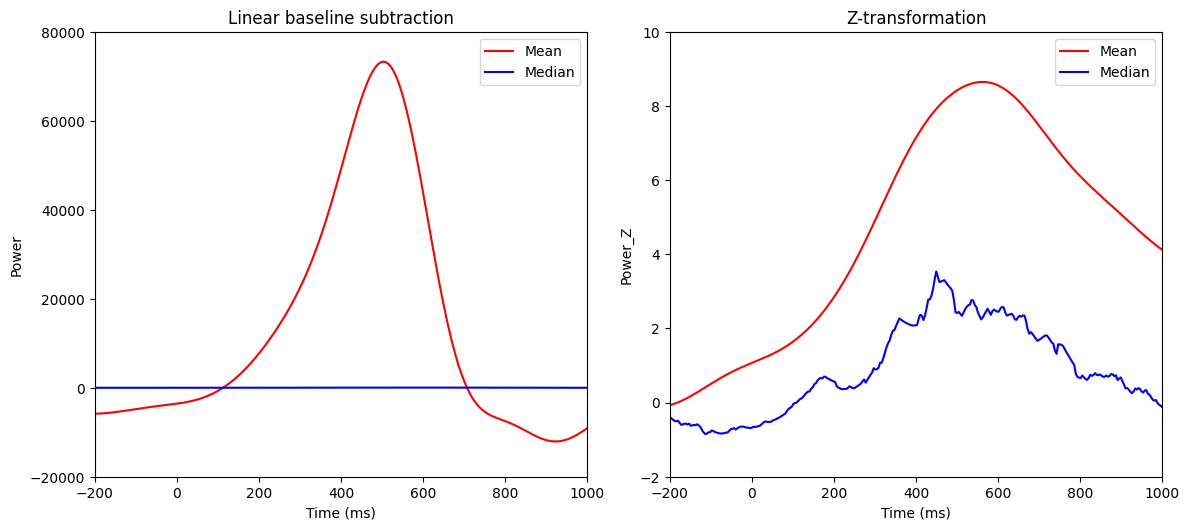

In [11]:
## Figure 18.10

# Convenientize power
convdatPower = np.abs(convdat2keep1)**2

# Single-trial linear baseline correction
convdat2keepB = convdatPower - np.mean(convdatPower[baselineidx[0]:baselineidx[1], :], axis=0)

# Single-trial Z score
convdat2keepZ = (convdatPower - np.mean(convdatPower[baselineidx[0]:baselineidx[1], :], axis=0)) / np.std(convdatPower[baselineidx[0]:baselineidx[1], :], axis=0)

# Single-trial log10
convdat2keepL = np.log10(convdatPower)

# Plot
plt.figure(figsize=(12, 10))

# Subplot 1: Linear baseline subtraction
plt.subplot(221)
plt.plot(EEG['times'][0], np.mean(convdat2keepB, axis=1), 'r', label='Mean')
plt.plot(EEG['times'][0], np.median(convdat2keepB, axis=1), 'b', label='Median')
plt.xlim([-200, 1000])
plt.ylim([-20000, 80000])
plt.xlabel('Time (ms)')
plt.ylabel('Power')
plt.legend()
plt.title('Linear baseline subtraction')

# Subplot 2: Z-transformation
plt.subplot(222)
plt.plot(EEG['times'][0], np.mean(convdat2keepZ, axis=1), 'r', label='Mean')
plt.plot(EEG['times'][0], np.median(convdat2keepZ, axis=1), 'b', label='Median')
plt.xlim([-200, 1000])
plt.ylim([-2, 10])
plt.xlabel('Time (ms)')
plt.ylabel('Power_Z')
plt.legend()
plt.title('Z-transformation')

plt.tight_layout()
plt.show()

In [12]:
## Figure 18.11

# This figure was made by running the code for figure 18.8 but using P1
# instead of FCz. (Fewer frequencies were also plotted.)

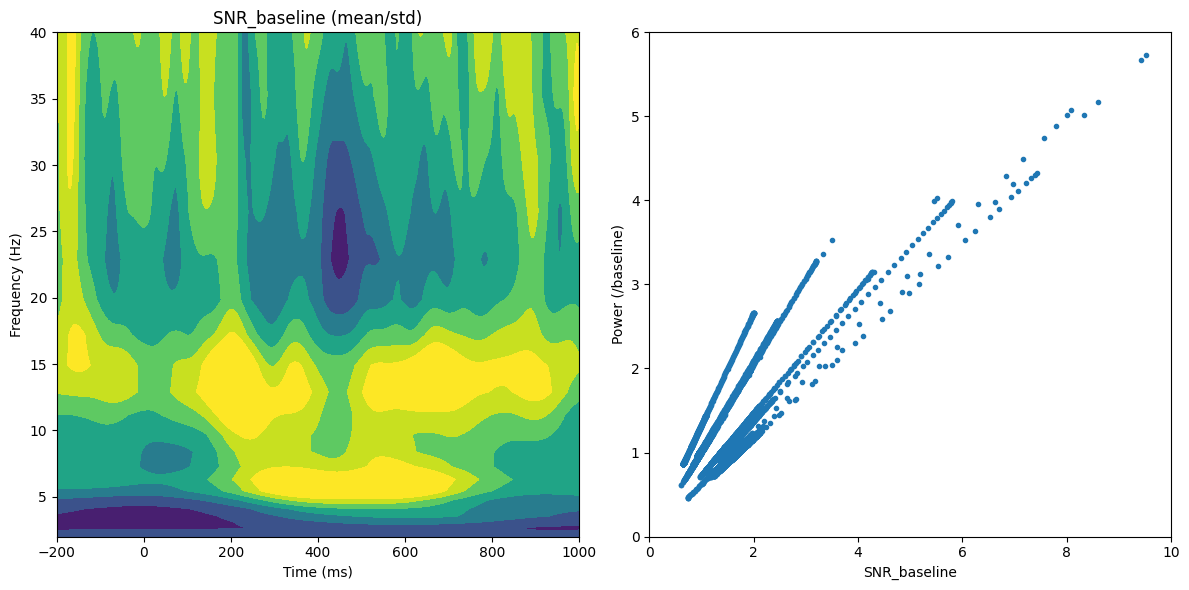

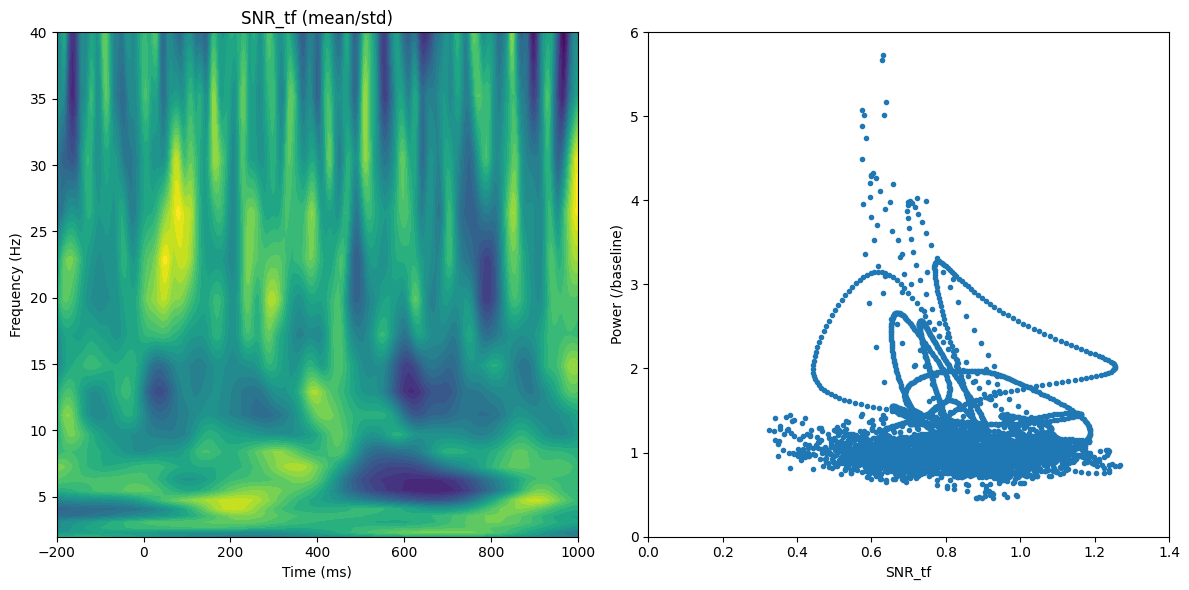

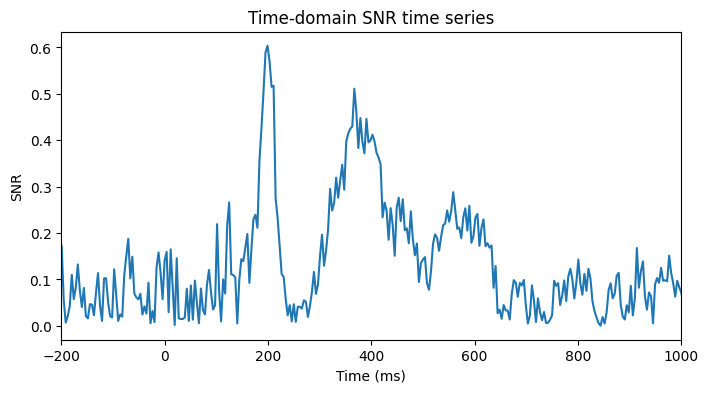

ERP SNR between 150 and 400 ms at FCz: 10.508532524108887


In [22]:
## Figure 18.12

# Initialize SNR and trial-averaged power arrays
snr_bs = np.zeros((len(frequencies), EEG['pnts'][0][0]))
snr_tf = np.zeros((len(frequencies), EEG['pnts'][0][0]))
tf = np.zeros((len(frequencies), EEG['pnts'][0][0]))

# Compute SNR and trial-averaged power for each frequency
for fi in range(len(frequencies)):
    # Create wavelet and get its FFT
    wavelet = np.exp(2 * 1j * np.pi * frequencies[fi] * time) * np.exp(-time**2 / (2 * (wavelet_cycles / (2 * np.pi * frequencies[fi]))**2)) / frequencies[fi]
    fft_wavelet = fft(wavelet, n_conv_pow2)
    
    # Run convolution
    convolution_result = ifft(fft_wavelet * fft_data, n_conv_pow2) * np.sqrt(wavelet_cycles /(2 * np.pi * frequencies[fi]))
    convolution_result = convolution_result[:n_convolution]
    convolution_result = convolution_result[half_of_wavelet_size: -half_of_wavelet_size]
    convolution_result = np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Extract SNR in two ways
    snr_tf[fi, :] = np.mean(np.abs(convolution_result)**2, axis=1) / np.std(np.abs(convolution_result)**2, axis=1)
    snr_bs[fi, :] = np.mean(np.abs(convolution_result)**2, axis=1) / np.std(np.mean(np.abs(convolution_result[baselineidx[0]:baselineidx[1], :])**2, axis=0))
    
    # Extract trial-averaged power
    tf[fi, :] = np.mean(np.abs(convolution_result)**2, axis=1)

# Plot SNR_baseline and SNR_tf
plt.figure(figsize=(12, 6))

# Subplot 1: SNR_baseline (mean/std)
plt.subplot(121)
plt.contourf(EEG['times'][0], frequencies, snr_bs, 40, cmap='viridis')
# plt.colorbar()
plt.clim(0.5, 2)
plt.xlim([-200, 1000])
plt.ylim([frequencies[0], 40])
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('SNR_baseline (mean/std)')

# Subplot 2: Relationship between SNR_baseline and Power/baseline
plt.subplot(122)
baseline_power = np.mean(tf[:, baselineidx[0]:baselineidx[1]], axis=1)
baselinediv = tf / baseline_power[:, np.newaxis]
plt.plot(snr_bs.flatten('F')[::3], baselinediv.flatten('F')[::3], '.')
plt.xlim([0, 10])
plt.ylim([0, 6])
plt.xlabel('SNR_baseline')
plt.ylabel('Power (/baseline)')

plt.tight_layout()
plt.show()

# Plot SNR_tf
plt.figure(figsize=(12, 6))

# Subplot 1: SNR_tf (mean/std)
plt.subplot(121)
plt.contourf(EEG['times'][0], frequencies, snr_tf, 40, cmap='viridis')
# plt.colorbar()
plt.clim(0.5, 1.25)
plt.xlim([-200, 1000])
plt.ylim([frequencies[0], 40])
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('SNR_tf (mean/std)')

# Subplot 2: Relationship between SNR_tf and Power/baseline
plt.subplot(122)
plt.plot(snr_tf.flatten('F')[::3], baselinediv.flatten('F')[::3], '.')
plt.xlim([0, 1.4])
plt.ylim([0, 6])
plt.xlabel('SNR_tf')
plt.ylabel('Power (/baseline)')

plt.tight_layout()
plt.show()

# Time-series of SNR
plt.figure(figsize=(8, 4))
mean_data = np.mean(EEG['data'][46, :, :], axis=1)
std_data = np.std(EEG['data'][46, :, :], axis=1)
plt.plot(EEG['times'][0], np.abs(mean_data / std_data))
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.title('Time-domain SNR time series')
plt.show()

# Compute SNR of peak compared to prestim noise
stimeidx = np.argmin(np.abs(EEG['times'][0] - 150))
etimeidx = np.argmin(np.abs(EEG['times'][0] - 400))
erp_snr = np.max(mean_data[stimeidx:etimeidx]) / np.std(mean_data[baselineidx[0]:baselineidx[1]])
print(f'ERP SNR between 150 and 400 ms at FCz: {erp_snr}')

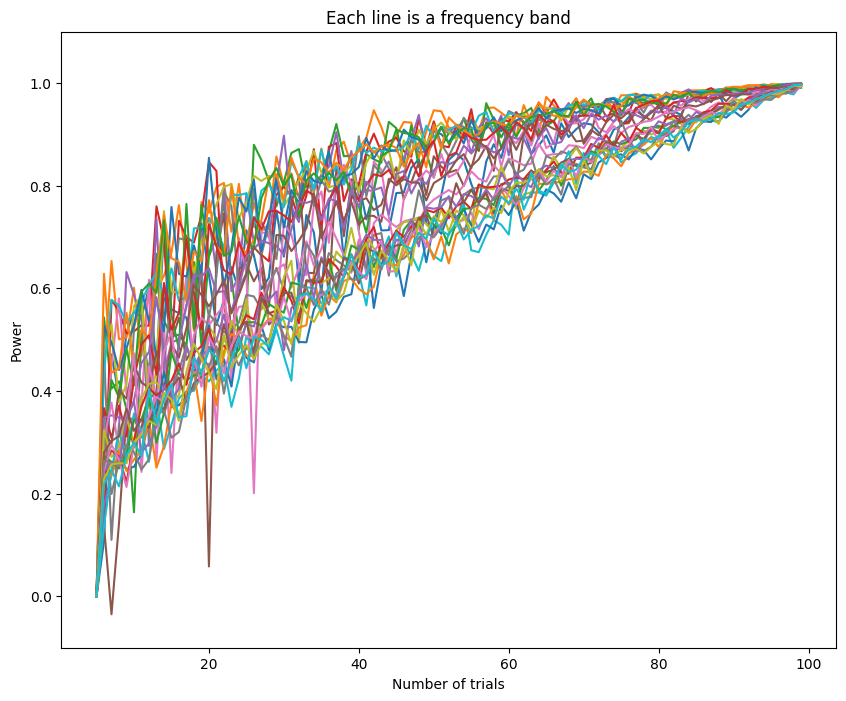

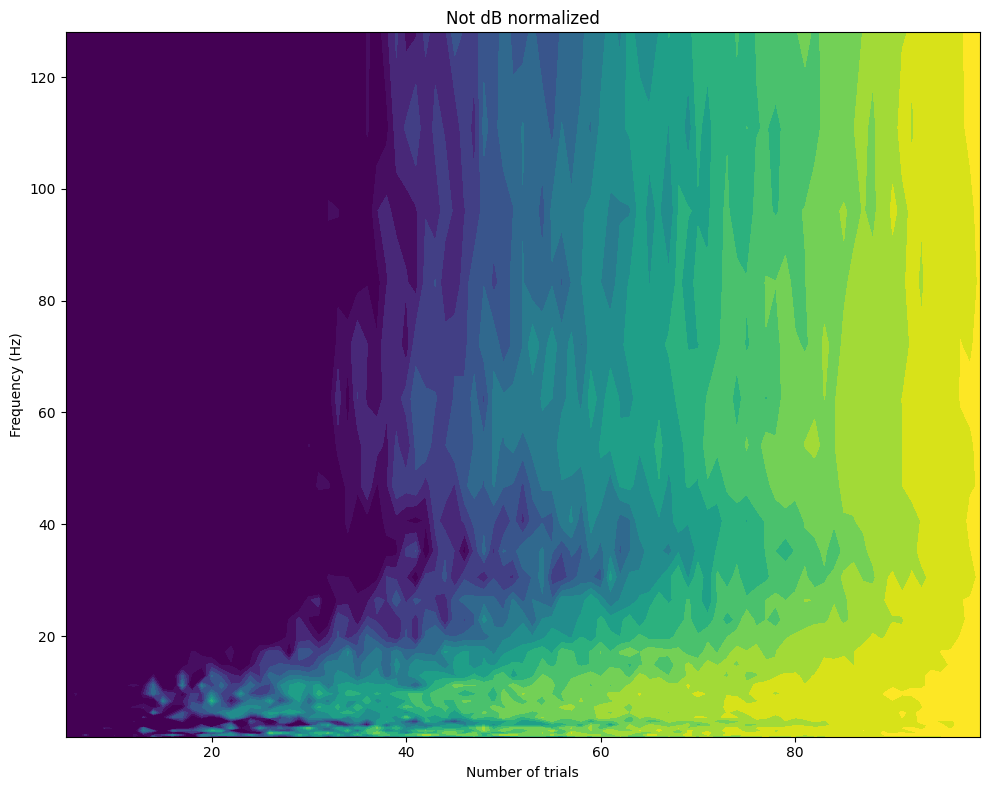

In [35]:
## Figure 18.13

# Initialize variables
iterations = 10
chan2plot = 'P7'  # or FCz
dbcorrect = False

powerByTrialFreq = np.zeros((len(frequencies), EEG['trials'][0][0]))

# Define time range
start_time = -200  # in ms
end_time = 1200

# FFT of data
fft_data = fft(EEG['data'][EEG['chanlocs'][0]['labels']==chan2plot].flatten('F'), n_conv_pow2)
timeidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in [start_time, end_time]]

# Compute power by trial frequency
for fi in range(len(frequencies)):
    # Create wavelet and get its FFT
    wavelet = np.exp(2 * 1j * np.pi * frequencies[fi] * time) * np.exp(-time**2 / (2 * (wavelet_cycles / (2 * np.pi * frequencies[fi]))**2)) / frequencies[fi]
    fft_wavelet = fft(wavelet, n_conv_pow2)
    
    # Run convolution
    convolution_result = ifft(fft_wavelet * fft_data, n_conv_pow2) * np.sqrt(wavelet_cycles / (2 * np.pi * frequencies[fi]))
    convolution_result = convolution_result[:n_convolution]
    convolution_result = convolution_result[half_of_wavelet_size: -half_of_wavelet_size]
    convolution_result = np.abs(np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F'))**2  # reshape and convert to power
    
    # "Gold standard" is average of all trials
    if dbcorrect:
        template = 10 * np.log10(np.mean(convolution_result, axis=1) / np.mean(np.mean(convolution_result[baselineidx[0]:baselineidx[1], :], axis=0)))
        template = template[timeidx[0]:timeidx[1]]
    else:
        template = np.mean(convolution_result[timeidx[0]:timeidx[1]], axis=1)
    template = (template - np.mean(template)) / np.std(template)
    
    for iteri in range(iterations):
        for triali in range(5, EEG['trials'][0][0]):  # start at 5 trials...
            trials2use = np.random.choice(EEG['trials'][0][0], triali, replace=False)
            
            # Compute power time series from the random selection of trials
            if dbcorrect:
                tempdat = 10 * np.log10(np.mean(convolution_result[:, trials2use], axis=1) / np.mean(np.mean(convolution_result[baselineidx[0]:baselineidx[1], trials2use])))
                tempdat = tempdat[timeidx[0]:timeidx[1]]
            else:
                tempdat = np.mean(convolution_result[timeidx[0]:timeidx[1], trials2use], axis=1)
            tempdat = (tempdat - np.mean(tempdat)) / np.std(tempdat)
            
            # Compute Pearson correlation
            powerByTrialFreq[fi, triali] += np.dot(tempdat, template) / np.dot(tempdat, tempdat)

powerByTrialFreq /= iterations

# Plot
plt.figure(figsize=(10, 8))
plt.plot(np.arange(5, EEG['trials'][0][0] + 1), powerByTrialFreq[:, 4:].T)
plt.xlabel('Number of trials')
plt.ylabel('Power')
plt.ylim([-0.1, 1.1])
plt.title('Each line is a frequency band')

plt.figure(figsize=(10, 8))
plt.contourf(np.arange(5, EEG['trials'][0][0] + 1), frequencies, powerByTrialFreq[:, 4:], 40, cmap='viridis')
plt.clim(0.6, 1)
plt.xlabel('Number of trials')
plt.ylabel('Frequency (Hz)')
plt.title('DB normalized' if dbcorrect else 'Not dB normalized')

plt.tight_layout()
plt.show()